# 1. Visualizing Project Rankings 
This following Python script visualizes project rankings across different voting methods using a bar plot. 

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

PT2IN = 1 / 72.27
twocol_pt = 487.8225
onecol_pt = 234.8775
aspect = 16 / 9

width_onecol_in = onecol_pt * PT2IN
width_twocol_in = twocol_pt * PT2IN

plt.rc('font', size=7)
plt.rc('xtick', labelsize=7)
plt.rc('ytick', labelsize=7)
plt.rc('axes', titlesize=9, labelsize=8)
plt.rc('legend', fontsize=8)
plt.rc('figure', titlesize=8, labelsize=8)
plt.rc('font', family='Avenir')

def set_figsize(width=width_onecol_in, aspect=aspect):
    return (width, width / aspect)

def visualize_project_rankings(filenames, instruction_labels, top_color='#E65100', bottom_color='#00695C'):
    kapp_h_filename = filenames.get('kapp_h', filenames.get('kapp'))
    baseline_df = pd.read_csv(kapp_h_filename)
    midpoint = len(baseline_df) // 2
    baseline_df['Label'] = ['Top' if i < midpoint else 'Bottom' for i in range(len(baseline_df))]
    baseline_df['Alpha'] = 0.3
    for rank, alpha in zip([1, 2, 3, 22, 23, 24], [0.8, 0.7, 0.6, 0.6, 0.7, 0.8]):
        baseline_df.loc[baseline_df['Rank'] == rank, 'Alpha'] = alpha

    all_dfs = []
    for method, filename in filenames.items():
        df = pd.read_csv(filename)
        df = df.merge(baseline_df[['Id', 'Label']], on='Id', how='left')
        df['Method'] = method
        df['Color'] = df['Id'].map(baseline_df.set_index('Id')['Rank'].apply(lambda x: plt.cm.viridis((x - 1) / (len(baseline_df) - 1))))
        all_dfs.append(df)

    combined_df = pd.concat(all_dfs).merge(baseline_df[['Id', 'Alpha']], on='Id', how='left')
    combined_df['Alpha'] = combined_df['Alpha'].astype(float)
    combined_df['Color'] = combined_df['Label'].map({'Top': top_color, 'Bottom': bottom_color})
    combined_df['Method'] = pd.Categorical(combined_df['Method'], categories=list(instruction_labels.keys()), ordered=True)

    fig, ax = plt.subplots(figsize=set_figsize(aspect=1), facecolor='white')
    ax.set_facecolor('white')

    bar_width, bar_height = 0.9, 0.8
    for method_pos, method in enumerate(instruction_labels.keys()):
        method_df = combined_df[combined_df['Method'] == method]
        for _, row in method_df.iterrows():
            left_edge = method_pos - bar_width / 2
            ax.barh(y=row['Rank'], width=bar_width, height=bar_height, left=left_edge, color=row['Color'], alpha=row['Alpha'], edgecolor='none')
            ax.text(left_edge + 0.03, row['Rank'], f"{row['Id']} {row['Name'][:3]}..", ha='left', va='center', color='black')

    ax.set_xticks(range(len(instruction_labels)))
    ax.set_xticklabels([instruction_labels[method] for method in instruction_labels], fontweight='bold', rotation=45)
    ax.set_ylabel('Rank', fontweight='bold')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis='both', which='both', length=0)

    y_ticks = np.arange(1, len(baseline_df) + 1)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(map(str, y_ticks))
    ax.set_xlim(-0.5, len(instruction_labels) - 0.5)
    ax.set_ylim(0, max(baseline_df['Rank']) + 0.5)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.subplots_adjust(top=0.9, bottom=0.1, right=0.9, left=0.05)
    plt.show()


# Kendall's Tau Correlation Heatmap for Project Rankings

This script visualizes Kendall's Tau correlations between different project ranking methods. The heatmap highlights the strength and direction of correlations, helping to compare and analyze the consistency across various ranking methods.

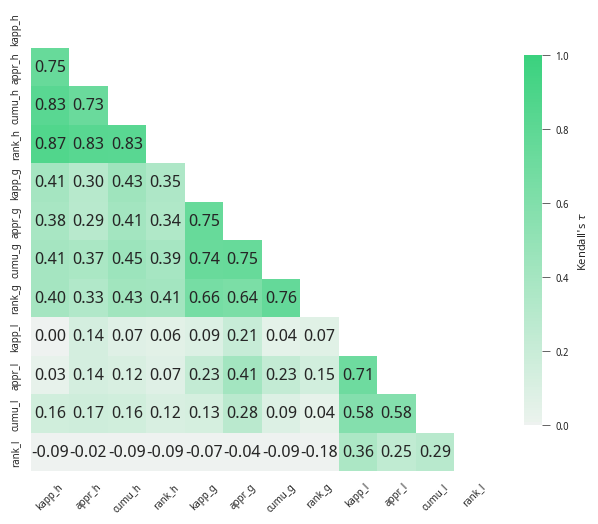

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
import numpy as np
from itertools import combinations

def visualize_kendalls_tau_heatmap(filenames, instruction_labels, vmin, vmax):
    dataframes = {label: pd.read_csv(filename) for label, filename in filenames.items()}
    tau_values = pd.DataFrame(index=filenames.keys(), columns=filenames.keys())
    
    for (method1, df1), (method2, df2) in combinations(dataframes.items(), 2):
        merged_df = df1.merge(df2, on='Id', suffixes=('_1', '_2'))
        tau, _ = kendalltau(merged_df['Rank_1'], merged_df['Rank_2'])
        tau_values.at[method1, method2] = tau
        tau_values.at[method2, method1] = tau

    np.fill_diagonal(tau_values.values, np.nan)
    tau_values = tau_values.astype(float)
    
    mask = np.triu(np.ones_like(tau_values, dtype=bool))
    cmap = sns.diverging_palette(220, 140, s=90, l=75, center='light', as_cmap=True)
    
    plt.figure(figsize=(8, 6))
    plt.rcParams['font.family'] = 'Noto Sans'
    ax = sns.heatmap(
        tau_values, cmap=cmap, center=0, cbar=True, vmin=vmin, vmax=vmax, 
        square=True, linewidths=0, annot_kws={"size": 12}, cbar_kws={"shrink": .8, 'label': 'Kendall\'s $\\tau$'}, 
        annot=True, fmt=".2f", mask=mask
    )
    ax.set_facecolor('white')
    plt.xticks(rotation=45)
    
    avg_taus = {}
    groups = {'_h': 'Human', '_g': 'GPT4T', '_l': 'LLaMA2'}
    for group_suffix, group_name in groups.items():
        group_keys = [key for key in filenames.keys() if key.endswith(group_suffix)]
        group_taus = [tau_values.at[key1, key2] for key1, key2 in combinations(group_keys, 2)]
        avg_taus[group_name] = np.nanmean(group_taus)
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.tick_params(axis='both', pad=1)
    c_bar = ax.collections[0].colorbar
    c_bar.ax.tick_params(width=0.5)

filenames = {
    'kapp_h': 'lab_vote/outcome_lab_kapp.csv',
    'appr_h': 'lab_vote/outcome_lab_appr.csv',
    'cumu_h': 'lab_vote/outcome_lab_cumu.csv',
    'rank_h': 'lab_vote/outcome_lab_rank.csv',
    'kapp_g': 'gpt_vote/outcome_kapp.csv',
    'appr_g': 'gpt_vote/outcome_appr.csv',
    'cumu_g': 'gpt_vote/outcome_cumu_corrected.csv',
    'rank_g': 'gpt_vote/outcome_rank.csv',
    'kapp_l': 'llama_vote/outcome_llama70bq8_kapp_1.csv',
    'appr_l': 'llama_vote/outcome_llama70bq8_appr_1.csv',
    'cumu_l': 'llama_vote/outcome_llama70bq8_cumu_1_corr.csv',
    'rank_l': 'llama_vote/outcome_llama70bq8_rank_1.csv',
}

instruction_labels = filenames

fig = visualize_kendalls_tau_heatmap(filenames, instruction_labels, 0, 1)


# Visualizing Project Rankings Across Voting Methods

The following code visualizes project rankings from various voting methods using a horizontal bar plot. Rankings are categorized into "Top" and "Bottom" groups, and colored accordingly.

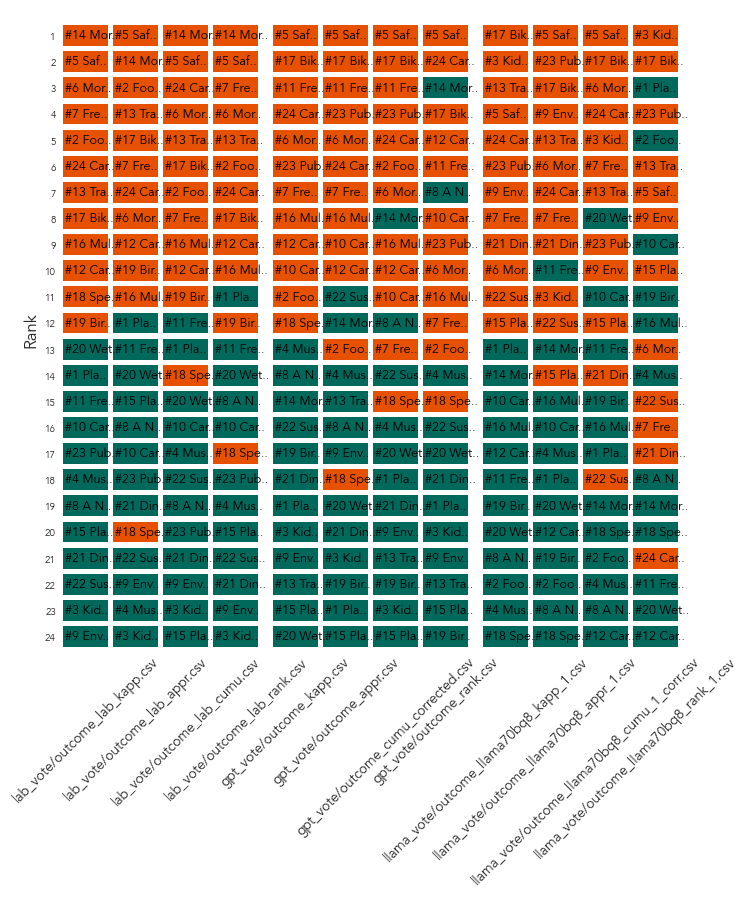

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def vis_rankings(filenames, instruction_labels, top_color='#E65100', bottom_color='#00695C'):
    baseline_filenames = {
        '_h': filenames.get('kapp_h'),
        '_g': filenames.get('kapp_g'),
        '_l': filenames.get('kapp_l'),
    }

    all_dfs = []

    for method, filename in filenames.items():
        df = pd.read_csv(filename)

        # Find the appropriate baseline file based on the suffix
        baseline_df = None
        for suffix, baseline_filename in baseline_filenames.items():
            if method.endswith(suffix):
                baseline_df = pd.read_csv(baseline_filename)
                break
        
        if baseline_df is None:
            continue

        # Set 'Top' or 'Bottom' labels and alpha values based on rank
        midpoint = len(baseline_df) // 2
        baseline_df['Label'] = ['Top' if i < midpoint else 'Bottom' for i in range(len(baseline_df))]
        baseline_df['Alpha'] = 0.3
        for rank, alpha in zip([1, 2, 3], [0.8, 0.7, 0.6]):
            baseline_df.loc[baseline_df['Rank'] == rank, 'Alpha'] = alpha

        # Merge baseline labels and alphas with current dataframe
        df = df.merge(baseline_df[['Id', 'Label', 'Alpha']], on='Id', how='left')
        df['Method'] = method
        df['Color'] = df['Id'].map(baseline_df.set_index('Id')['Rank'].apply(lambda x: plt.cm.viridis((x - 1) / (len(baseline_df) - 1))))
        all_dfs.append(df)

    # Combine all dataframes
    combined_df = pd.concat(all_dfs)
    combined_df['Alpha'] = 1

    plt.rcParams['font.family'] = 'Avenir'
    fig, ax = plt.subplots(figsize=(8, 8), facecolor='white')
    ax.set_facecolor('white')

    methods_order = list(instruction_labels.keys())
    combined_df['Method'] = pd.Categorical(combined_df['Method'], categories=methods_order, ordered=True)
    combined_df['Color'] = combined_df['Label'].map({'Top': top_color, 'Bottom': bottom_color})

    bar_width, bar_height, group_gap = 0.9, 0.8, 0.2

    # Plot each method's data
    for method_pos, method in enumerate(methods_order):
        group_offset = (method_pos // 4) * group_gap
        method_df = combined_df[combined_df['Method'] == method]
        for _, row in method_df.iterrows():
            left_edge = method_pos - bar_width / 2 + group_offset
            ax.barh(y=row['Rank'], width=bar_width, height=bar_height, left=left_edge,
                    color=row['Color'], alpha=row['Alpha'], edgecolor='none')
            ax.text(left_edge + 0.03, row['Rank'], f"{row['Id']} {row['Name'][:3]}..",
                    ha='left', va='center', fontsize=9, color='black')

    # Configure plot appearance
    ax.set_xticks(range(len(methods_order)))
    ax.set_xticklabels([instruction_labels[method] for method in methods_order], fontsize=10, fontweight='bold', rotation=45)
    ax.set_ylabel('Rank', fontsize=12, fontweight='bold')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis='both', which='both', length=0)

    y_ticks = np.arange(1, len(baseline_df) + 1)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(map(str, y_ticks))
    ax.set_xlim(-0.5, len(methods_order) - 0.5 + group_offset * (len(methods_order) // 3))
    ax.set_ylim(0, max(baseline_df['Rank']) + 0.5)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.subplots_adjust(top=0.9, bottom=0.1, right=0.9, left=0.05)
    plt.show()

vis_rankings(filenames, instruction_labels)


# Kendall's Tau Heatmap Visualization Across Different Temperature Settings

This script creates a heatmap to visualize Kendall's Tau correlation coefficients between different LLM models at various temperature settings. It compares rankings from different datasets to assess how temperature variations affect the ranking similarity.

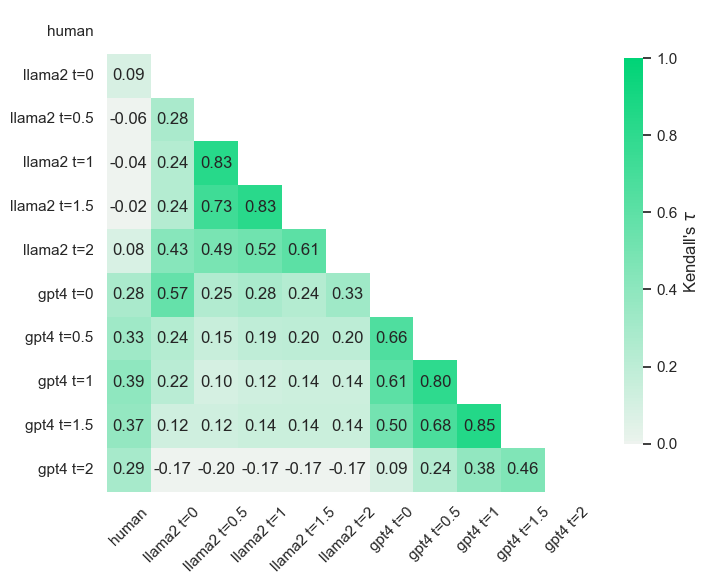

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
import numpy as np
from itertools import combinations
import matplotlib

# Set the global font for all plots
matplotlib.rc('font', family='Noto Sans')

def visualize_kendalls_tau_heatmap(filenames, instruction_labels, vmin, vmax):
    """
    Visualizes a heatmap of Kendall's Tau coefficients for comparing different voting methods.
    """
    # Read data from files into a dictionary of DataFrames
    dataframes = {label: pd.read_csv(filename) for label, filename in filenames.items()}
    tau_values = pd.DataFrame(index=filenames.keys(), columns=filenames.keys(), dtype=float)

    # Compute Kendall's Tau for each pair of methods
    for (method1, df1), (method2, df2) in combinations(dataframes.items(), 2):
        merged_df = df1.merge(df2, on='Id', suffixes=('_1', '_2'))
        tau, _ = kendalltau(merged_df['Rank_1'], merged_df['Rank_2'])
        tau_values.at[method1, method2] = tau
        tau_values.at[method2, method1] = tau

    # Set diagonal to NaN to ignore self-comparisons
    np.fill_diagonal(tau_values.values, np.nan)

    # Create mask for upper triangle
    mask = np.triu(np.ones_like(tau_values, dtype=bool))

    # Set up the color palette and plot style
    cmap = sns.diverging_palette(220, 140, s=100, l=75, center='light', as_cmap=True)
    sns.set(style='white', font_scale=1.0)

    # Create the heatmap
    plt.figure(figsize=(8, 6))
    heatmap = sns.heatmap(
        tau_values, cmap=cmap, center=0, cbar=True, vmin=vmin, vmax=vmax,
        square=True, linewidths=0, annot_kws={"size": 12}, 
        cbar_kws={"shrink": .8, 'label': "Kendall's $\\tau$"}, 
        annot=True, fmt=".2f", mask=mask
    )

    # Set formatted labels for ticks
    formatted_labels = [instruction_labels[label] for label in tau_values.index]
    heatmap.set_xticklabels(formatted_labels, rotation=45)
    heatmap.set_yticklabels(formatted_labels, rotation=0)

    # Adjust layout and save the figure
    plt.tight_layout()
    plt.savefig('../figures/kendalls_tau_heatmap.pdf', format='pdf', bbox_inches='tight')
    plt.show()

# Define file paths and labels with the specified instruction_labels
filenames = {
    'human': 'lab_vote/outcome_lab_kapp.csv',
    'llama2_t0': 'llama_temp/temp0/outcome.csv',
    'llama2_t0p5': 'llama_temp/temp0p5/outcome.csv',
    'llama2_t1': 'llama_temp/temp1/outcome.csv',
    'llama2_t1p5': 'llama_temp/temp1p5/outcome.csv',
    'llama2_t2': 'llama_temp/temp2/outcome.csv',
    'gpt4_t0': 'gpt_temp/temp0/outcome.csv',
    'gpt4_t0p5': 'gpt_temp/temp0p5/outcome.csv',
    'gpt4_t1': 'gpt_temp/temp1/outcome.csv',
    'gpt4_t1p5': 'gpt_temp/temp1p5/outcome.csv',
    'gpt4_t2': 'gpt_temp/temp2/outcome.csv',
}

instruction_labels = {
    'human': 'human',
    'llama2_t0': 'llama2 t=0',
    'llama2_t0p5': 'llama2 t=0.5',
    'llama2_t1': 'llama2 t=1',
    'llama2_t1p5': 'llama2 t=1.5',
    'llama2_t2': 'llama2 t=2',
    'gpt4_t0': 'gpt4 t=0',
    'gpt4_t0p5': 'gpt4 t=0.5',
    'gpt4_t1': 'gpt4 t=1',
    'gpt4_t1p5': 'gpt4 t=1.5',
    'gpt4_t2': 'gpt4 t=2',
}

visualize_kendalls_tau_heatmap(filenames, instruction_labels, vmin=0, vmax=1)


# Stacked Bar Charts for Vote Distribution Across Different Models and Methods

This script visualizes the vote distribution across different models and methods using stacked bar charts. It reads vote data from multiple CSV files, normalizes the votes to percentages, and plots the distribution by district, category, and cost.


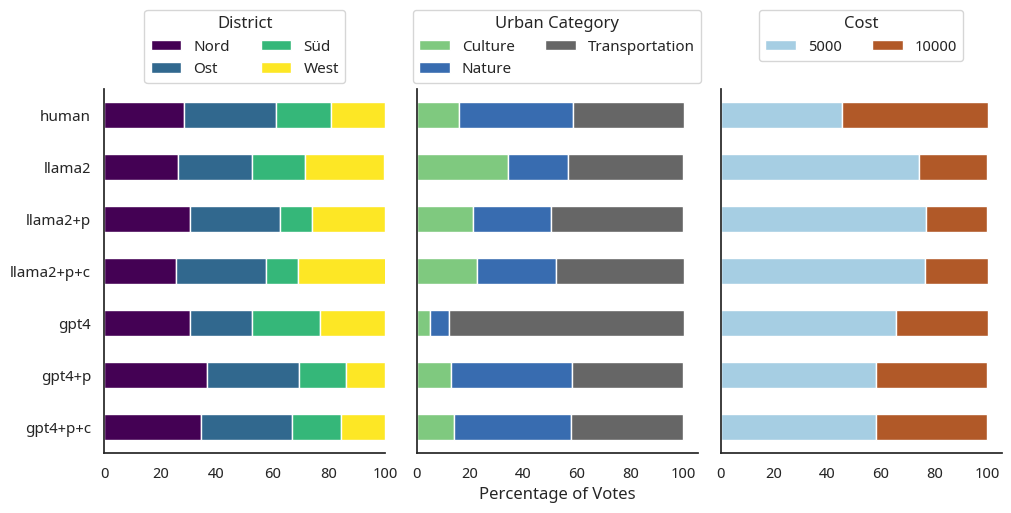

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# File paths for different outcomes
filenames = {
    'human': 'lab_vote/outcome_lab_kapp.csv',
    'llama2_t1': 'llama_temp/temp1/outcome.csv',
    'llama2_persona': 'llama_persona/temp1/llama2_outcomes.csv',
    'llama2_cot': 'llama2_cot_vote_temp1/outcome_llama2_cot_kapp_1.csv',
    'gpt4_t1': 'gpt_temp/temp1/outcome.csv',
    'gpt4_persona': 'gpt_persona/temp1/gpt_outcome.csv',
    'gpt_cot': 'gpt_cot/gpt_outcome.csv'
}

# Labels for instructions
instruction_labels = {
    'human': 'human',
    'llama2_t1': 'llama2',
    'llama2_persona': 'llama2+p',
    'llama2_cot': 'llama2+p+c',
    'gpt4_t1': 'gpt4',
    'gpt4_persona': 'gpt4+p',
    'gpt_cot': 'gpt4+p+c'
}

# Function to calculate vote distribution by district, category, and cost
def calculate_vote_distribution(filename):
    df = pd.read_csv(filename)
    district_votes = df.groupby('District')['Votes'].sum()
    category_votes = df.groupby('Category')['Votes'].sum()
    cost_votes = df.groupby('Cost')['Votes'].sum()
    return district_votes, category_votes, cost_votes

# Prepare the data for the stacked bar chart
all_district_votes = {}
all_category_votes = {}
all_cost_votes = {}

for key, filename in filenames.items():
    district_votes, category_votes, cost_votes = calculate_vote_distribution(filename)
    
    # Normalize the votes to percentages (total votes is always 900)
    total_votes = 900
    district_votes = (district_votes / total_votes) * 100
    category_votes = (category_votes / total_votes) * 100
    cost_votes = (cost_votes / total_votes) * 100

    all_district_votes[key] = district_votes.to_dict()
    all_category_votes[key] = category_votes.to_dict()
    all_cost_votes[key] = cost_votes.to_dict()

# Convert dictionaries to DataFrames and transpose them
district_df = pd.DataFrame(all_district_votes).T.fillna(0)
category_df = pd.DataFrame(all_category_votes).T.fillna(0)
cost_df = pd.DataFrame(all_cost_votes).T.fillna(0)

# Define x-axis labels based on instruction labels
x_labels = [instruction_labels[key] for key in filenames.keys()]

# Plotting setup
fig, axes = plt.subplots(1, 3, figsize=(10, 5), sharey=True, constrained_layout=True)
plt.rcParams['font.family'] = 'Noto Sans'

# Plotting the data
district_df.plot(kind='barh', stacked=True, ax=axes[0], colormap='viridis')
axes[0].legend(title='District', loc='upper center', bbox_to_anchor=(0.5, 1.24), ncol=2)
axes[0].set_yticklabels(x_labels, rotation=0)
axes[0].invert_yaxis()

category_df.plot(kind='barh', stacked=True, ax=axes[1], colormap='Accent')
axes[1].legend(title='Urban Category', loc='upper center', bbox_to_anchor=(0.5, 1.24), ncol=2)
axes[1].set_xlabel('Percentage of Votes')
axes[1].set_yticklabels(x_labels, rotation=0)
axes[1].invert_yaxis()

cost_df.plot(kind='barh', stacked=True, ax=axes[2], colormap='Paired')
axes[2].legend(title='Cost', loc='upper center', bbox_to_anchor=(0.5, 1.24), ncol=3)
axes[2].set_yticklabels(x_labels, rotation=0)
axes[2].invert_yaxis()

# Set common properties
axes[0].set_xlim(0, 100)
sns.despine()
# plt.savefig("../figures/voting_dist.pdf", format='pdf')
plt.show()


# Average Jaccard Dissimilarity Calculation

This script calculates the average Jaccard dissimilarity between human voting patterns and various model-generated voting patterns. It reads JSON files containing vote data for different models and methods, computes the Jaccard dissimilarity between each model's votes and the human votes, and outputs the average dissimilarity for each model. 


In [26]:
import json
from itertools import combinations

def jaccard_dissimilarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 1

def read_json_file(file_path):
    with open(file_path, 'r') as file:
        return json.load(file)

def calculate_average_dissimilarity(data, human_votes):
    votes_sets = [set(agent["votes"]) for agent in data]
    human_votes_sets = [set(agent["votes"]) for agent in human_votes]
    dissimilarities = [jaccard_dissimilarity(votes_sets[i], human_votes_sets[i]) for i in range(len(human_votes_sets))]
    return sum(dissimilarities) / len(dissimilarities) if dissimilarities else 0

filenames = {
    'human': 'lab_vote/votes_kapp.json',
    'llama2': 'llama_temp/temp1/votes.json',
    'llama2_persona': 'llama_persona/temp1/llama2_votes.json',
    'llama2_cot': 'llama2_cot_vote_temp1/votes_llama2_cot_kapp_1.json',
    'gpt4': 'gpt_temp/temp1/votes.json',
    'gpt4_persona': 'gpt_persona/temp1/gpt_votes.json',
    'gpt4_cot': 'gpt_cot/gpt_votes.json',
}

average_dissimilarities = {}
human_votes = read_json_file('lab_vote/votes_kapp.json')

for label, filepath in filenames.items():
    data = read_json_file(filepath)
    average_dissimilarity = calculate_average_dissimilarity(data, human_votes)
    average_dissimilarities[label] = average_dissimilarity

print("Average Jaccard Dissimilarity:")
print("-------------------------------")
print("{:<15} {:<15}".format('Group', 'Similarity'))
for group, dissimilarity in average_dissimilarities.items():
    print("{:<15} {:<15}".format(group, dissimilarity))


Average Jaccard Dissimilarity:
-------------------------------
Group           Similarity     
human           1.0            
llama2          0.13476631393298044
llama2_persona  0.20809082892416222
llama2_cot      0.1858004649671315
gpt4            0.1781966490299822
gpt4_persona    0.3001102292768962
gpt4_cot        0.2998789482122818


# Box Plot of Jaccard Dissimilarity Between Individual Votes Across Different Models

This script generates a box plot to illustrate the Jaccard dissimilarity between individual votes from human voters and those generated by LLaMA-2 and GPT-4 models at various temperature settings. The Jaccard dissimilarity measures the extent of difference between vote sets, with values closer to 1 indicating greater deviation and less similarity in voting patterns. The plot includes a red line representing the mean dissimilarity for each group, along with the numerical mean value for a clear comparison of voting behaviors.

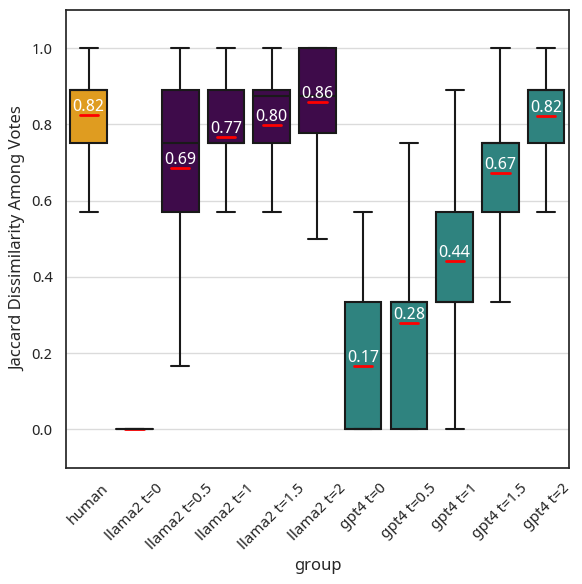

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import json

def read_json_file(filepath):
    with open(filepath, 'r') as file:
        return json.load(file)

def jaccard_dissimilarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return 1 - intersection / union if union != 0 else 1

def calculate_dissimilarities(data):
    votes_sets = [set(agent["votes"]) for agent in data]
    return [jaccard_dissimilarity(set1, set2) for set1, set2 in combinations(votes_sets, 2)]

# Filepaths for different outcomes
filenames = {
    'human': 'lab_vote/votes_kapp.json',
    'llama2 t=0': 'llama_temp/temp0/votes.json',
    'llama2 t=0.5': 'llama_temp/temp0p5/votes.json',
    'llama2 t=1': 'llama_temp/temp1/votes.json',
    'llama2 t=1.5': 'llama_temp/temp1p5/votes.json',
    'llama2 t=2': 'llama_temp/temp2/votes.json',
    'gpt4 t=0': 'gpt_temp/temp0/votes.json',
    'gpt4 t=0.5': 'gpt_temp/temp0p5/votes.json',
    'gpt4 t=1': 'gpt_temp/temp1/votes.json',
    'gpt4 t=1.5': 'gpt_temp/temp1p5/votes.json',
    'gpt4 t=2': 'gpt_temp/temp2/votes.json',
}

# Compute dissimilarities
dissimilarities_data = []
for label, filepath in filenames.items():
    data = read_json_file(filepath)
    dissimilarities = calculate_dissimilarities(data)
    dissimilarities_data.extend({'group': label, 'dissimilarity': d} for d in dissimilarities)

df = pd.DataFrame(dissimilarities_data)

# Define colors for each group
colors = {
    'human': '#ffa600',
    'gpt4': '#21918c',
    'llama2': '#440154'
}
color_map = {label: colors['gpt4'] if 'gpt4' in label else colors['llama2'] if 'llama2' in label else colors['human'] for label in df['group'].unique()}

# Plotting
plt.figure(figsize=(6, 6))
plt.rcParams['font.family'] = 'Noto Sans'
ax = sns.boxplot(x='group', y='dissimilarity', data=df, palette=color_map, showfliers=False)

# Annotate mean on each boxplot
for i, group in enumerate(df['group'].unique()):
    group_data = df[df['group'] == group]['dissimilarity']
    mean = group_data.mean()
    plt.plot([i - 0.2, i + 0.2], [mean, mean], color='red', lw=2)  # Short red line for mean
    plt.text(i, mean, f'{mean:.2f}', color='white', ha='center', va='bottom')

# Configure plot labels and layout
plt.ylabel('Jaccard Dissimilarity Among Votes')
plt.ylim(-0.1, 1.1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='-', alpha=0.7)
# plt.savefig('../figures/jaccard-diversity.pdf', format='pdf')
plt.show()


# Box Plots of Vote Distribution by Self-Identified Interests

This script generates box plots to visualize the distribution of vote percentages that align with voters' self-identified district and category interests. The plots compare different groups, including human voters, LLaMA-2, and GPT-4 models, under various conditions. Red lines represent median values, and diamond symbols indicate mean values for each group. A random voting scenario is included to provide a baseline comparison against outcomes that reflect specific voting preferences.


/var/folders/b5/wqbw_0tx7wv2s6m_tw4pfw7h0000gq/T/ipykernel_15181/4018868878.py:94: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=total_df, x='variable', hue='Type', y='Percentage', dodge=0.4, join=False,


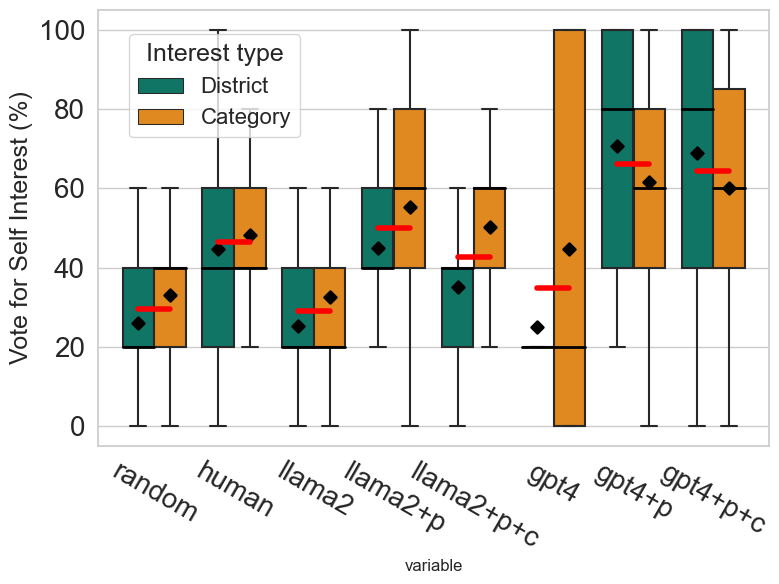

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import random
import os

# Load voter metadata
voter_meta_df = pd.read_csv('../data/lab_meta.csv')
voter_meta = voter_meta_df[['1st Topic', 'District']].to_dict(orient='records')

def simulate_random_votes(num_voters, num_projects, num_choices):
    """Simulate random votes for a given number of voters, projects, and choices."""
    return [{"votes": random.sample(range(1, num_projects + 1), num_choices)} for _ in range(num_voters)]

random_responses = simulate_random_votes(180, 24, 5)

# Define project mappings
project_mapping = {
    i + 1: {"District": district, "Category": category}
    for i, (district, category) in enumerate(
        [("Nord", "Nature"), ("Nord", "Nature"), ("Nord", "Culture"), ("Nord", "Culture"), 
         ("Nord", "Transport"), ("Nord", "Transport"), ("Süd", "Nature"), ("Süd", "Nature"), 
         ("Süd", "Culture"), ("Süd", "Culture"), ("Süd", "Transport"), ("Süd", "Transport"), 
         ("Ost", "Nature"), ("Ost", "Nature"), ("Ost", "Culture"), ("Ost", "Culture"), 
         ("Ost", "Transport"), ("Ost", "Transport"), ("West", "Nature"), ("West", "Nature"), 
         ("West", "Culture"), ("West", "Culture"), ("West", "Transport"), ("West", "Transport")]
    )
}

def calculate_vote_percentages(data, voter_meta):
    """Calculate the percentage of votes for self-interest based on district and category."""
    responses = data if not isinstance(data, str) else json.load(open(data, 'r'))
    district_vote_percentages = []
    category_vote_percentages = []

    for i, response in enumerate(responses):
        voter_district = voter_meta[i]['District']
        voter_category = voter_meta[i]['1st Topic']
        votes = response["votes"]

        district_vote_sum = sum(1 for project_id in votes if project_mapping[project_id]["District"] == voter_district)
        category_vote_sum = sum(1 for project_id in votes if project_mapping[project_id]["Category"] == voter_category)
        total_vote_sum = len(votes)

        district_vote_percentages.append((district_vote_sum / total_vote_sum) * 100)
        category_vote_percentages.append((category_vote_sum / total_vote_sum) * 100)
    
    return district_vote_percentages, category_vote_percentages

# File paths for vote data
filenames = {
    'random': random_responses,
    'human': 'lab_vote/votes_kapp.json',
    'llama2': 'llama_temp/temp1/votes.json',
    'llama2+p': 'llama_persona/temp1/llama2_votes.json',
    'llama2+p+c': 'llama2_cot_vote_temp1/votes_llama2_cot_kapp_1.json',
    'gpt4': 'gpt_temp/temp1/votes.json',
    'gpt4+p': 'gpt_persona/temp1/gpt_votes.json',
    'gpt4+p+c': 'gpt_cot/gpt_votes.json',
}

# Calculate percentages for all vote data
all_district_percentages = []
all_category_percentages = []

for key, filename in filenames.items():
    district_percentages, category_percentages = calculate_vote_percentages(filename, voter_meta)
    all_district_percentages.append(district_percentages)
    all_category_percentages.append(category_percentages)

# Create dataframes for district and category percentages
district_df = pd.DataFrame(all_district_percentages).T
district_df.columns = filenames.keys()
district_df['Type'] = 'District'

category_df = pd.DataFrame(all_category_percentages).T
category_df.columns = filenames.keys()
category_df['Type'] = 'Category'

# Combine dataframes for plotting
total_df = pd.concat([
    district_df.melt(id_vars='Type', value_name='Percentage'),
    category_df.melt(id_vars='Type', value_name='Percentage')
])

# Plotting setup
sns.set_style("whitegrid")
palette = sns.color_palette(["#018571", "darkorange"])

plt.figure(figsize=(8, 6))
ax = sns.boxplot(data=total_df, x='variable', hue='Type', y='Percentage', palette=palette,
                 medianprops=dict(linewidth=2, color='black'), fliersize=0)
sns.pointplot(data=total_df, x='variable', hue='Type', y='Percentage', dodge=0.4, join=False,
              palette=['black'], markers='D', scale=0.9, ci=None, ax=ax)

# Annotate mean values
for i, key in enumerate(filenames.keys()):
    mean = total_df[total_df['variable'] == key]['Percentage'].mean()
    plt.plot([i - 0.2, i + 0.2], [mean, mean], color='red', lw=4)

# Final plot adjustments
plt.ylabel('Vote for Self Interest (%)', fontsize=18)
plt.xticks(fontsize=20, rotation=330)
plt.yticks(fontsize=20)
plt.ylim(-5, 105)
plt.tight_layout()
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[:2], labels[:2], title='Interest type', title_fontsize=18, fontsize=16, bbox_to_anchor=(0.03, 0.97), loc='upper left')

# os.makedirs('../figures', exist_ok=True)
# plt.savefig('../figures/self.pdf', format='pdf')
plt.show()


# Jaccard Similarity Analysis of Model and Human Votes

This script calculates and visualizes the Jaccard similarity between human voting patterns and votes generated by different models, including LLaMA-2 and GPT-4 under various configurations. The plot includes a crimson line indicating the mean similarity for each group.

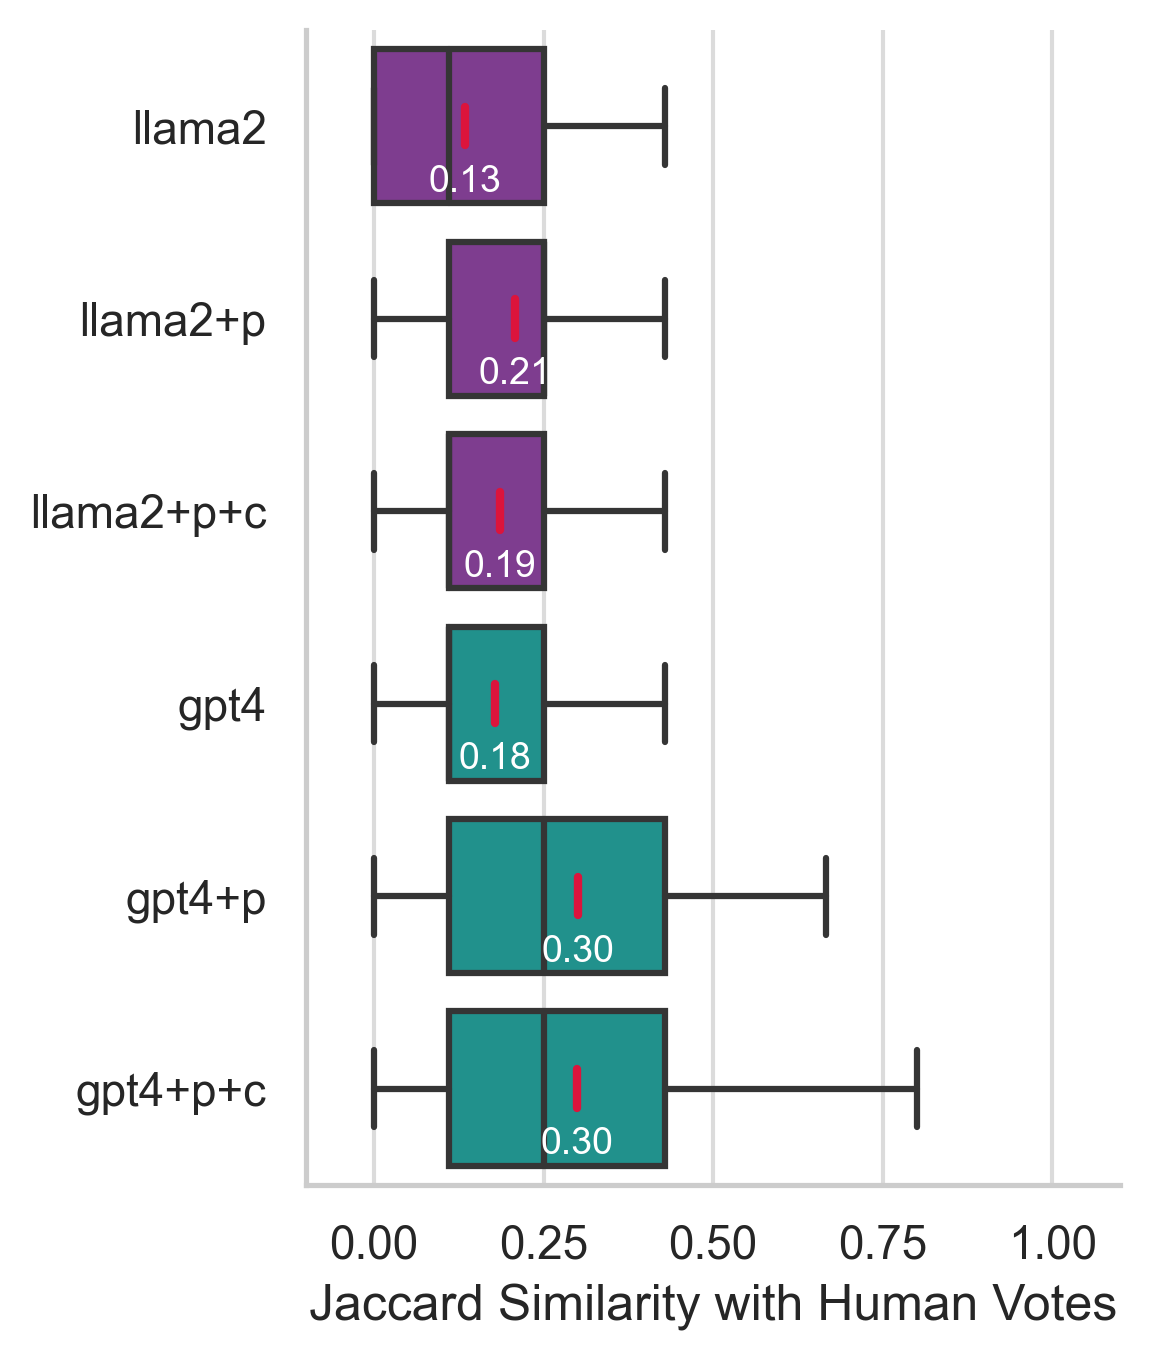

In [29]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

def jaccard_similarity(set1, set2):
    """Calculate the Jaccard similarity between two sets."""
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

def read_json_file(file_path):
    """Read and return JSON data from a file."""
    with open(file_path, 'r') as file:
        return json.load(file)

def calculate_similarities(data, human_votes):
    """Calculate Jaccard similarities between model votes and human votes."""
    votes_sets = [set(agent["votes"]) for agent in data]
    human_votes_sets = [set(agent["votes"]) for agent in human_votes]
    return [jaccard_similarity(votes_sets[i], human_votes_sets[i]) for i in range(len(human_votes_sets))]

# File paths for model votes
filenames = {
    'llama2': 'llama_temp/temp1/votes.json',
    'llama2+p': 'llama_persona/temp1/llama2_votes.json',
    'llama2+p+c': 'llama2_cot_vote_temp1/votes_llama2_cot_kapp_1.json',
    'gpt4': 'gpt_temp/temp1/votes.json',
    'gpt4+p': 'gpt_persona/temp1/gpt_votes.json',
    'gpt4+p+c': 'gpt_cot/gpt_votes.json',
}

# Read human votes data
human_votes = read_json_file('lab_vote/votes_kapp.json')

# Calculate similarities for each model
all_similarities = {}
for label, filepath in filenames.items():
    data = read_json_file(filepath)
    similarities = calculate_similarities(data, human_votes)
    all_similarities[label] = similarities

# Plotting setup
fig, ax = plt.subplots(figsize=(3.5, 5), dpi=300)

# Define color palette
llama_color = '#7e3d8f'
gpt_color = '#21918c'
color_map = {key: llama_color if 'llama' in key else gpt_color for key in filenames.keys()}
palette = [color_map[label] for label in filenames.keys()]

# Plot boxplot
sns.boxplot(data=list(all_similarities.values()), ax=ax, palette=palette, orient='h', saturation=1, showfliers=False)
plt.yticks(range(len(filenames)), list(filenames.keys()), rotation=0)
plt.xlabel('Jaccard Similarity with Human Votes')
plt.xlim(-0.1, 1.1)

# Annotate mean values
means = [np.mean(sim) for sim in all_similarities.values()]
for i, mean in enumerate(means):
    plt.plot([mean, mean], [i - 0.1, i + 0.1], color='crimson', lw=2)
    plt.text(mean, i + 0.2, f'{mean:.2f}', color='white', ha='center', va='top', fontsize=9)

# Customize plot appearance
plt.grid(axis='x', linestyle='-', alpha=0.7)
sns.despine()

# Add legend for mean line
handles = [Line2D([0], [0], color='crimson', lw=2)]
plt.show()


In [22]:
from scipy.stats import ttest_ind

gpt4_p_similarities = all_similarities['gpt4+p']
gpt4_p_c_similarities = all_similarities['gpt4+p+c']

t_stat, p_value = ttest_ind(gpt4_p_similarities, gpt4_p_c_similarities, equal_var=False)

print(f'T-statistic: {t_stat}, P-value: {p_value}')

T-statistic: 0.011857964485254049, P-value: 0.9905455452590803


In [30]:
from scipy.stats import ttest_ind

llama2_p_similarities = all_similarities['llama2+p']
llama2_p_c_similarities = all_similarities['llama2+p+c']

t_stat, p_value = ttest_ind(llama2_p_similarities, llama2_p_c_similarities, equal_var=False)

print(f'T-statistic: {t_stat}, P-value: {p_value}')

T-statistic: 1.6505551094574655, P-value: 0.09971509067049973


# Visualization of Vote Percentages Sorted by Project and Model/Temperature

This script generates a line plot to visualize the vote percentages for each project, sorted in descending order, across different models and temperature settings (GPT-4 and LLaMA-2). This visualization helps compare how different models and temperature settings affect voting outcomes.


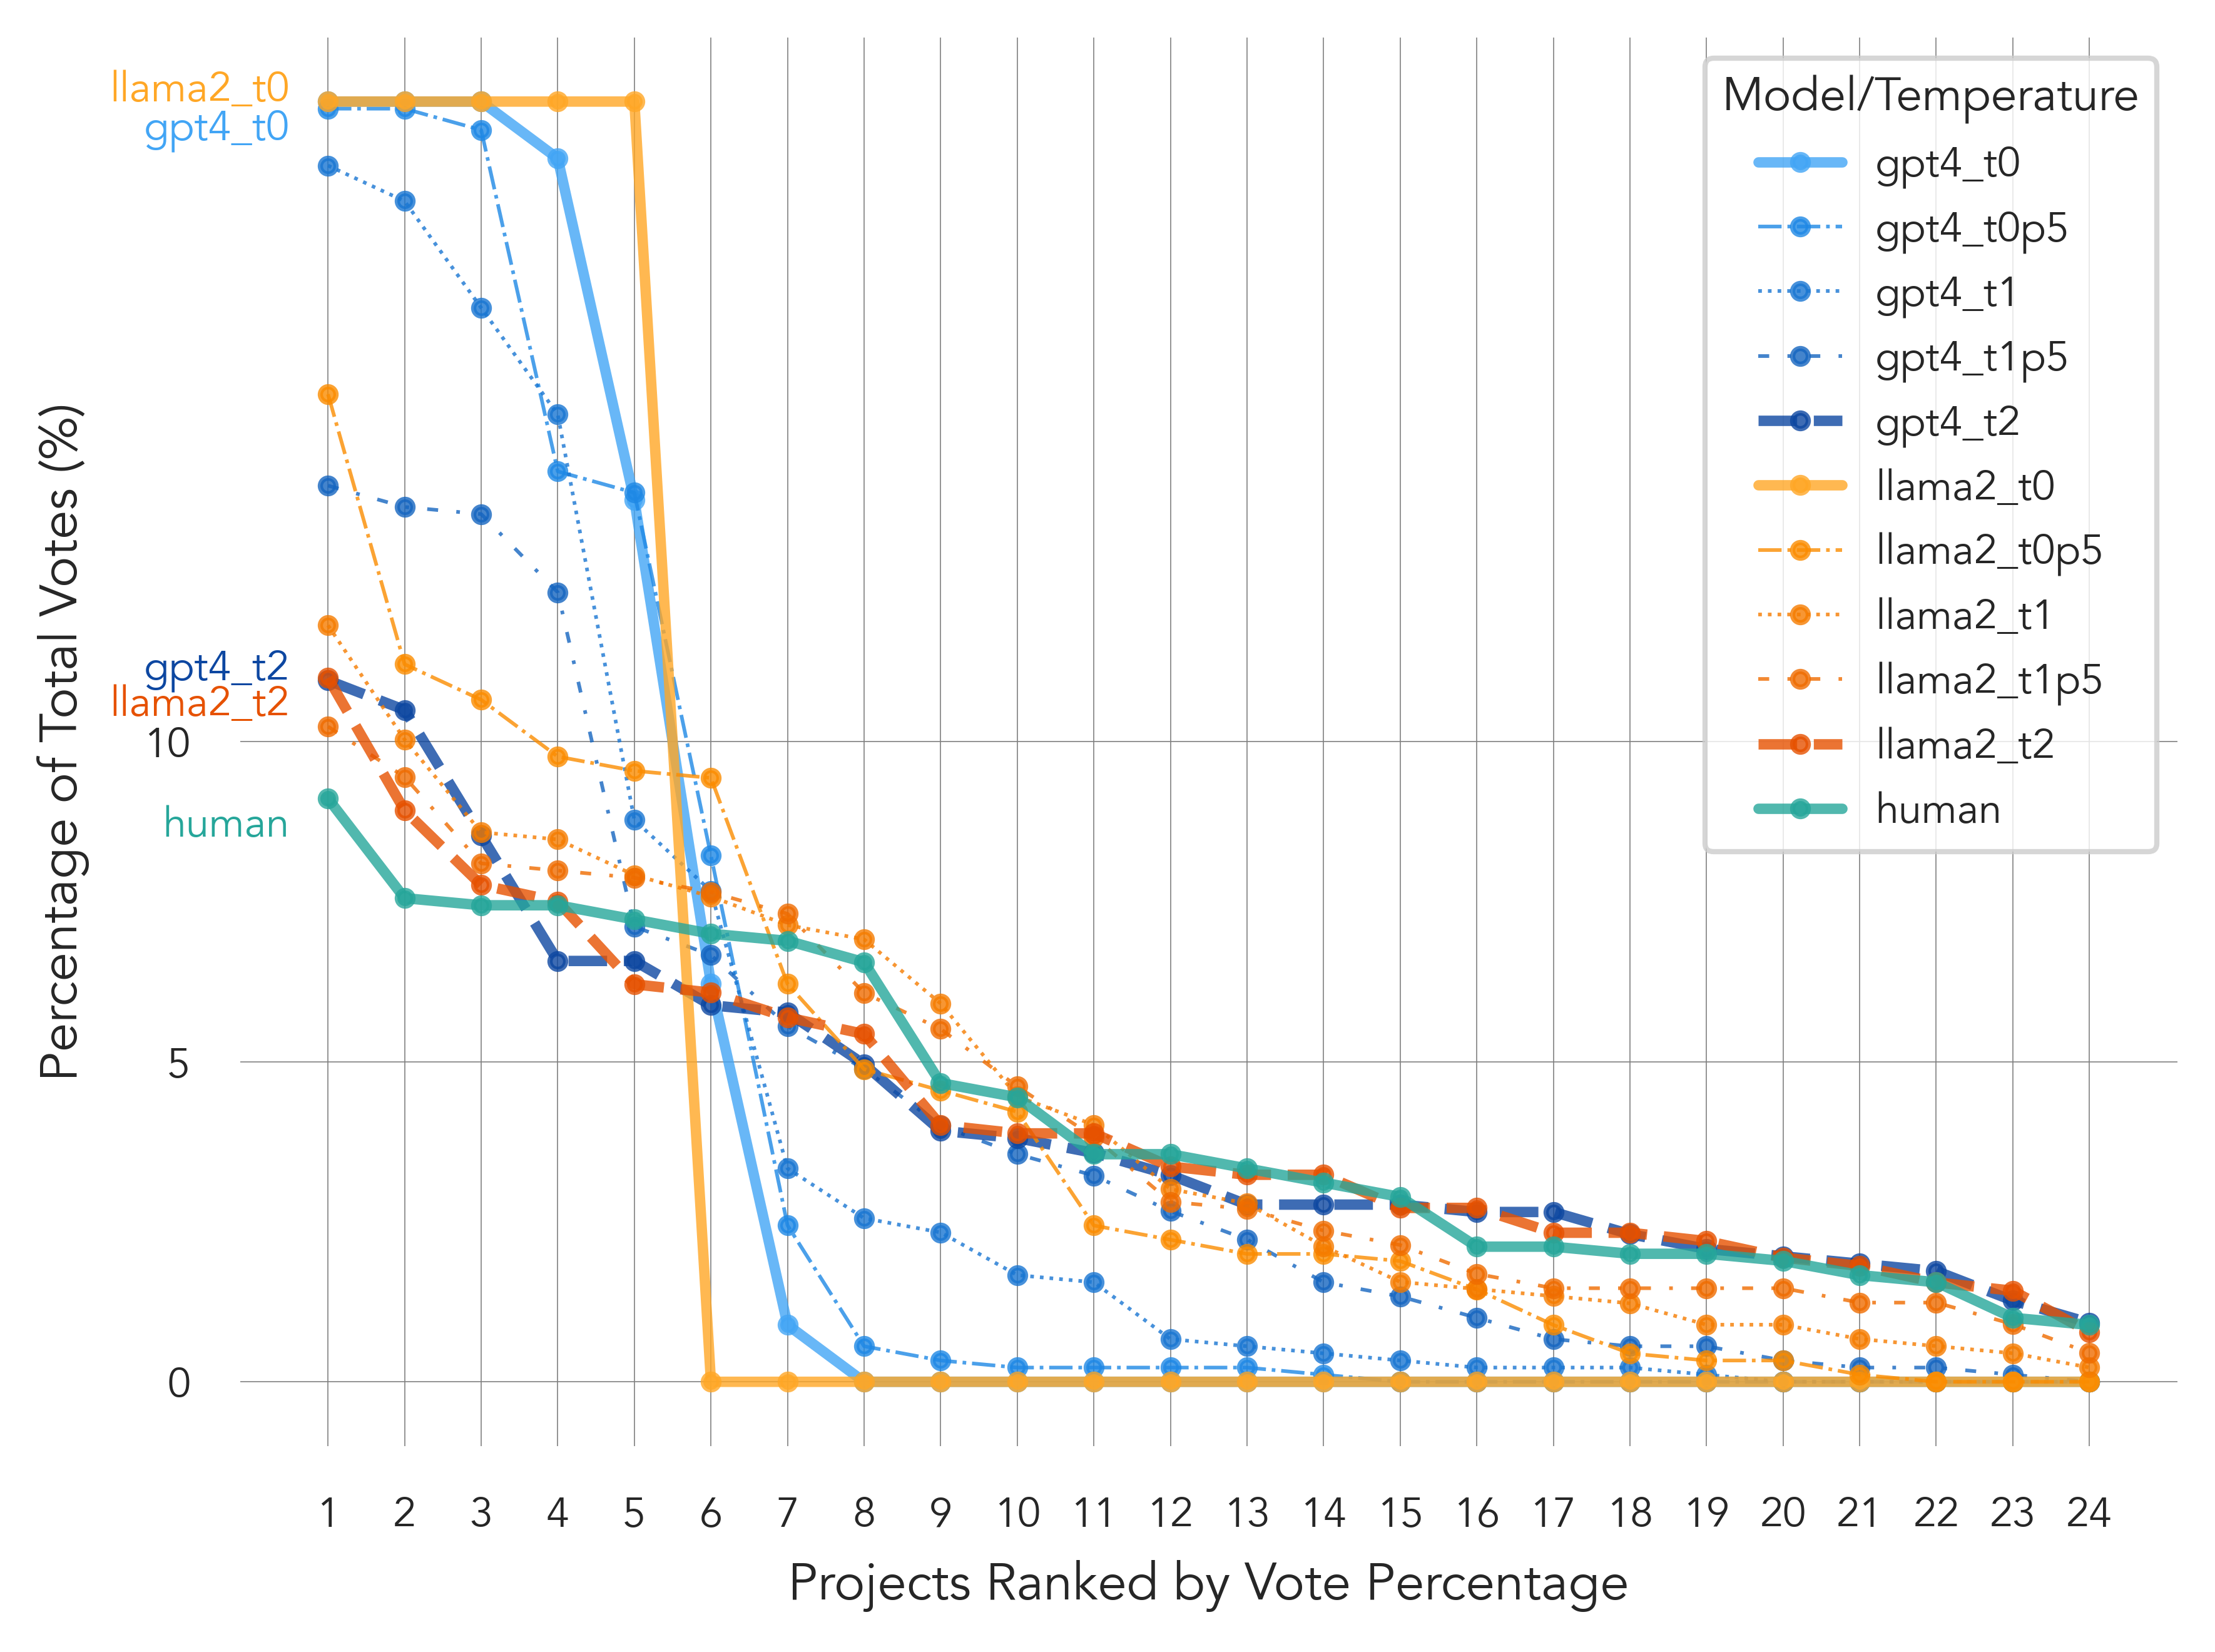

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def set_figsize(width=6, aspect=4/3):
    """Sets figure size based on width and aspect ratio."""
    return (width, width / aspect)

def visualize_vote_percentages_sorted_with_ids(filenames, color_scheme):
    """
    Visualizes the vote percentage of each project for each outcome file, sorted in descending order,
    with annotations for project IDs. Uses different color schemes for GPT and LLaMA data.
    """
    # Define color palettes and line styles
    blue_palette = ['#42A5F5', '#1E88E5', '#1976D2', '#1565C0', '#0D47A1']
    orange_palette = ['#FFA726', '#FB8C00', '#F57C00', '#EF6C00', '#E65100']
    teal_palette = ['#26A69A', '#009688', '#00897B', '#00796B', '#00695C']
    thicker_lw = 2
    line_styles = ['-', '-.', ':', (0, (3, 5, 1, 5)), '--']
    line_weights = {'llama2_t0': thicker_lw, 'llama2_t2': thicker_lw, 'gpt4_t0': thicker_lw, 'gpt4_t2': thicker_lw, 'human': thicker_lw}

    # Assign colors and line styles based on the label
    color_map = {}
    line_style_map = {}
    for i, label in enumerate(filenames):
        if 'gpt' in label:
            color_map[label] = blue_palette[i % len(blue_palette)]
        elif 'llama' in label:
            color_map[label] = orange_palette[i % len(orange_palette)]
        elif 'human' in label:
            color_map[label] = teal_palette[0]
        line_style_map[label] = line_styles[i % len(line_styles)]
    
    # Prepare data for plotting
    plots = {}
    for label, filename in filenames.items():
        df = pd.read_csv(filename)
        total_votes = df['Votes'].sum()
        df['Vote_Percentage'] = df['Votes'] / total_votes * 100
        sorted_df = df.sort_values('Vote_Percentage', ascending=False)
        plots[label] = {
            'percentages': sorted_df['Vote_Percentage'].reset_index(drop=True),
            'ids': sorted_df['Id']
        }

    # Set font size and family
    plt.rcParams.update({'font.size': 10, 'font.family': 'Avenir'})

    # Initialize the figure
    fig = plt.figure(figsize=set_figsize(aspect=4/3), dpi=600)

    # Plot each dataset
    for label, data in plots.items():
        color = color_map[label]
        line_style = line_style_map[label]
        line_weight = line_weights.get(label, 0.7)
        plt.plot(
            data['percentages'],
            marker='o',
            label=label,
            color=color,
            markersize=3,  # Increased marker size for visibility
            alpha=0.8,
            linestyle=line_style,
            linewidth=line_weight
        )

        # Annotate specific lines with labels
        if label in ['llama2_t0', 'llama2_t2', 'gpt4_t0', 'gpt4_t2', 'human']:
            y_pos = data['percentages'].iloc[0] + 0.5 if label in ['llama2_t0', 'gpt4_t2'] else data['percentages'].iloc[0] - 0.1
            x_pos = -0.5
            plt.text(x_pos, y_pos, f'{label}', color=color, ha='right', va='top', fontweight='bold', fontsize=8)

    # Final plot adjustments
    plt.xlabel('Projects Ranked by Vote Percentage', fontsize=10)
    plt.ylabel('Collective Votes (%)', fontsize=10)
    plt.legend(title='Model/Temperature', fontsize=8, title_fontsize=9, loc='upper right')
    plt.grid(which='major', linestyle='-', linewidth='0.2', color='grey')
    ax = plt.gca()
    ax.set_ylabel('Percentage of Total Votes (%)', labelpad=10, fontsize=10)
    ax.set_facecolor('white')
    plt.yticks([0, 5, 10], fontsize=8)
    plt.xticks(range(len(plots[next(iter(plots))]['percentages'])), range(1, len(plots[next(iter(plots))]['percentages']) + 1), fontsize=8)
    sns.despine(bottom=True, left=True)
    ax.tick_params(left=False, bottom=False)
    plt.tight_layout()

    return fig

# Filenames and color scheme definitions
filenames = {
    'gpt4_t0': 'gpt_temp/temp0/outcome.csv',
    'gpt4_t0p5': 'gpt_temp/temp0p5/outcome.csv',
    'gpt4_t1': 'gpt_temp/temp1/outcome.csv',
    'gpt4_t1p5': 'gpt_temp/temp1p5/outcome.csv',
    'gpt4_t2': 'gpt_temp/temp2/outcome.csv',
    'llama2_t0': 'llama_temp/temp0/outcome.csv',
    'llama2_t0p5': 'llama_temp/temp0p5/outcome.csv',
    'llama2_t1': 'llama_temp/temp1/outcome.csv',
    'llama2_t1p5': 'llama_temp/temp1p5/outcome.csv',
    'llama2_t2': 'llama_temp/temp2/outcome.csv',
    'human': 'lab_vote/outcome_lab_kapp.csv',
}

color_scheme = {
    'gpt': ['#1E88E5', '#1976D2', '#1565C0', '#0D47A1', '#0A37A3'],
    'llama': ['#FFA726', '#FB8C00', '#F57C00', '#EF6C00', '#E65100']
}

fig = visualize_vote_percentages_sorted_with_ids(filenames, color_scheme)
# fig.savefig('figures/temperature.pdf', bbox_inches='tight')


# Visualization of Vote Percentages Sorted by Project and Voting methods

This script generates a line plot to visualize the vote percentages for each project, sorted in descending order, across different voting methods. 


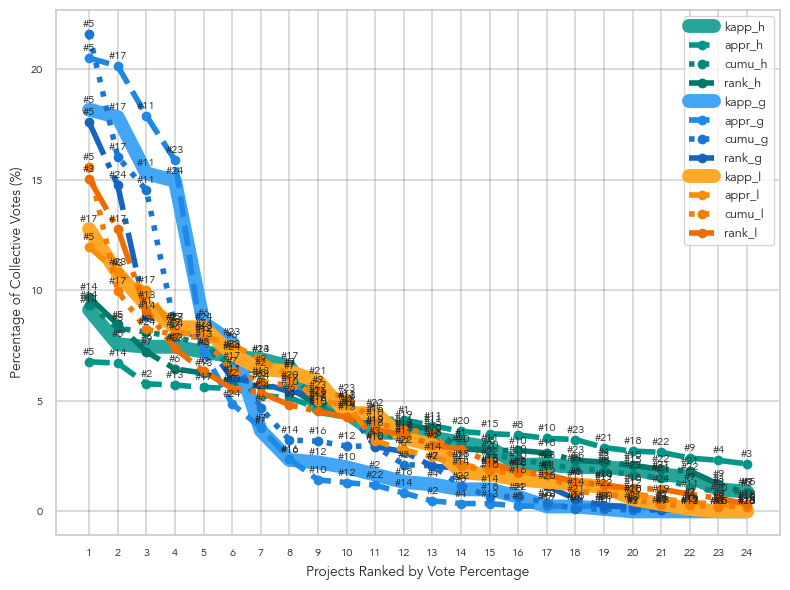

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from itertools import cycle

def visualize_vote_percentages_sorted_with_ids(filenames):
    """
    Visualizes the vote percentage of each project for each outcome file, sorted in descending order,
    with annotations for project IDs. Differentiates '1' methods by shades of orange and '2' methods by shades of teal.

    Parameters:
    - filenames: Dictionary with keys as method labels and values as filenames.
    """

    orange_palette = ['#FFA726', '#FB8C00', '#F57C00', '#EF6C00']  
    teal_palette = ['#26A69A', '#009688', '#00897B', '#00796B']    
    blue_palette = ['#42A5F5', '#1E88E5', '#1976D2', '#1565C0']   

    orange_cycle = cycle(orange_palette)
    teal_cycle = cycle(teal_palette)
    blue_cycle = cycle(blue_palette)

    line_styles = ['-', '--', ':', '-.']
    line_weights = ['10', '4', '4', '4']  

    # Assign colors based on method
    color_map = {}
    for method in filenames:
        if '_l' in method:
            color_map[method] = next(orange_cycle)
        elif '_g' in method:
            color_map[method] = next(blue_cycle)
        else:
            color_map[method] = next(teal_cycle)

    # Prepare data for plotting
    plots = {}
    for method, filename in filenames.items():
        df = pd.read_csv(filename)
        total_votes = df['Votes'].sum()
        df['Vote_Percentage'] = df['Votes'] / total_votes * 100
        sorted_df = df.sort_values('Vote_Percentage', ascending=False)
        plots[method] = {
            'percentages': sorted_df['Vote_Percentage'].reset_index(drop=True),
            'ids': sorted_df['Id']
        }
        
    # Set consistent font sizes
    plt.rcParams.update({'font.size': 10, 'font.family': 'Avenir'})

    # Initialize the figure
    plt.figure(figsize=(8, 6))

    # Plot each dataset
    for i, (method, data) in enumerate(plots.items()):
        color = color_map[method]
        line_style = line_styles[i % len(line_styles)]
        line_weight = int(line_weights[i % len(line_weights)])

        plt.plot(data['percentages'], marker='o', label=method, color=color, linewidth=line_weight, linestyle=line_style)
        
        # Annotate project IDs with consistent font size
        for j, txt in enumerate(data['ids']):
            plt.annotate(txt, (j, data['percentages'][j]), textcoords="offset points", xytext=(0,5), ha='center', fontsize=8)

    # Set axis labels and legend
    plt.xlabel('Projects Ranked by Vote Percentage', fontsize=10)
    plt.ylabel('Percentage of Collective Votes (%)', fontsize=10)
    plt.legend(fontsize=9)
    plt.grid(which='major', linestyle='-', linewidth='0.2', color='black')
    plt.minorticks_on()

    # Configure axis ticks and minor ticks
    ax = plt.gca()
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.set_facecolor('white')
    plt.xticks(range(len(plots[next(iter(plots))]['percentages'])), range(1, len(plots[next(iter(plots))]['percentages']) + 1), fontsize=8)
    plt.yticks(fontsize=8)

    plt.tight_layout()
    plt.show()

filenames = {
    'kapp_h': 'lab_vote/outcome_lab_kapp.csv',
    'appr_h': 'lab_vote/outcome_lab_appr.csv',
    'cumu_h': 'lab_vote/outcome_lab_cumu.csv',
    'rank_h': 'lab_vote/outcome_lab_rank.csv',
    'kapp_g': 'gpt_vote/outcome_kapp.csv',
    'appr_g': 'gpt_vote/outcome_appr.csv',
    'cumu_g': 'gpt_vote/outcome_cumu_corrected.csv',
    'rank_g': 'gpt_vote/outcome_rank.csv',
    'kapp_l': 'llama_vote/outcome_llama70bq8_kapp_1.csv',
    'appr_l': 'llama_vote/outcome_llama70bq8_appr_1.csv',
    'cumu_l': 'llama_vote/outcome_llama70bq8_cumu_1.csv',
    'rank_l': 'llama_vote/outcome_llama70bq8_rank_1.csv',
}

visualize_vote_percentages_sorted_with_ids(filenames)


# Direct Visualization of Pecentage Differences Between Human and Model-Generated Votes

This script compares the vote distributions between human participants and two AI models, LLaMA and GPT-4, using approval voting data from various projects. The visualization highlights which projects received more or fewer votes from models compared to human voters, using different colors for positive and negative differences. 

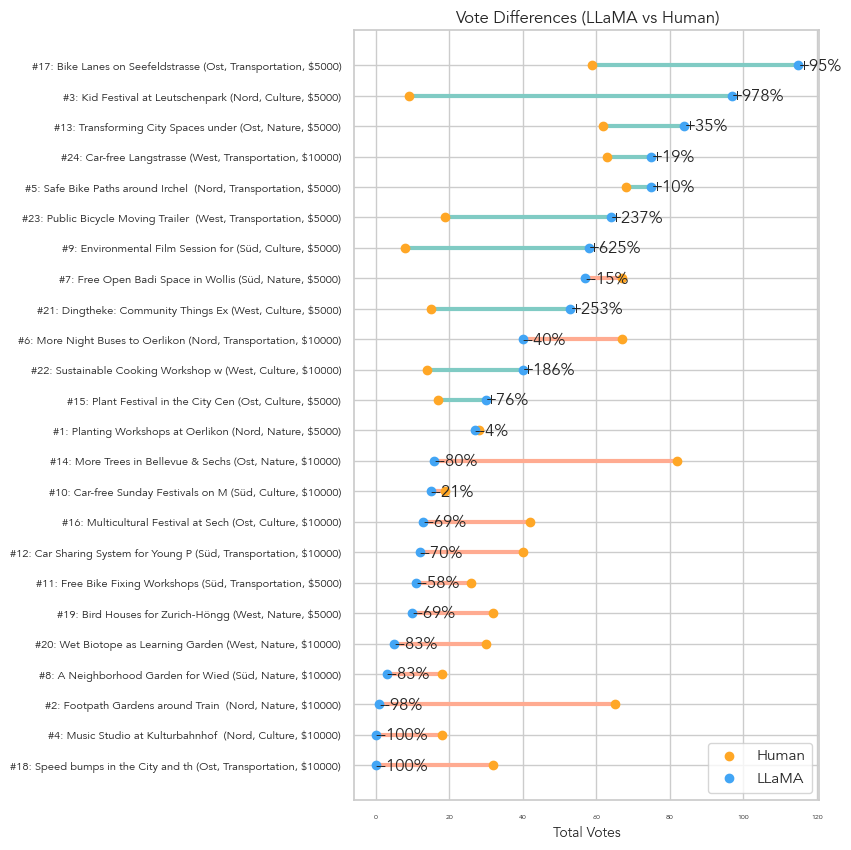

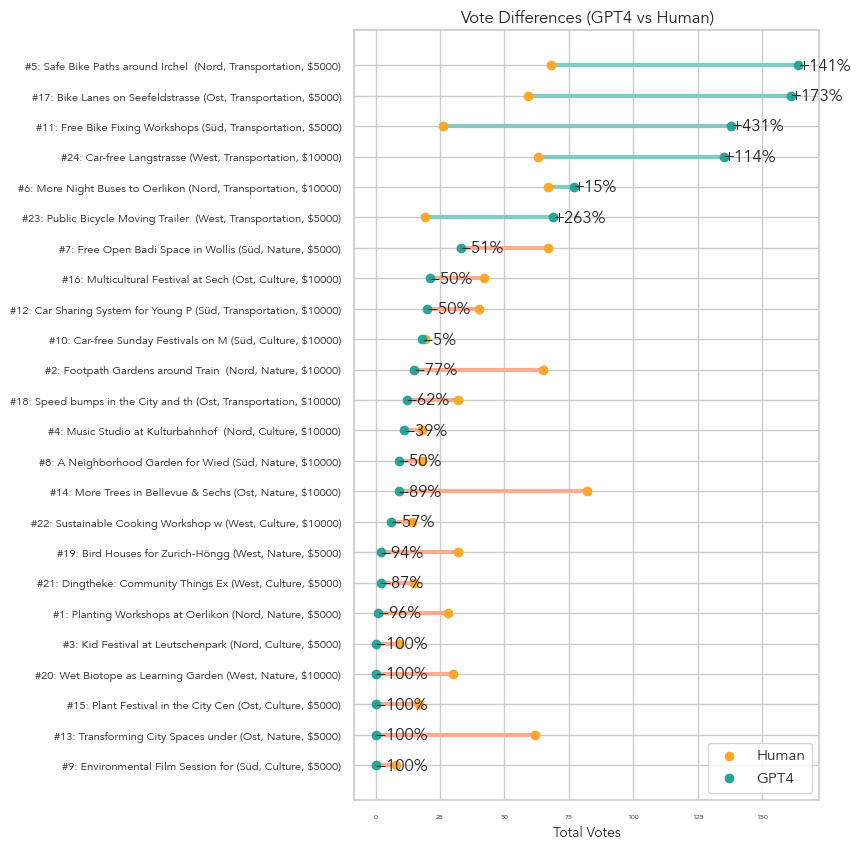

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 10, 'font.family': 'Avenir'})

def parse_project_info(project_info):
    """Parses project information from a dictionary into a structured format."""
    parsed_info = {}
    for key, info in project_info.items():
        parts = info.split(', ')
        name = parts[0]
        details = ', '.join(parts[1:])
        parsed_info[key] = {'name': name, 'details': details}
    return parsed_info

def visualize_vote_differences(filenames, project_info):
    """Visualizes vote differences between human and model-generated votes."""
    parsed_info = parse_project_info(project_info)

    # Load data from CSV files
    kapp_h_df = pd.read_csv(filenames['kapp_h'])
    kapp_llama_df = pd.read_csv(filenames['kapp_l'])
    kapp_g_df = pd.read_csv(filenames['kapp_g'])

    def process_df(df1, df2, suffix_h, suffix_other):
        """Merges and processes two dataframes to calculate vote percentage differences."""
        merged_df = df1[['Id', 'Votes']].merge(df2[['Id', 'Votes']], on='Id', suffixes=(suffix_h, suffix_other))
        merged_df['Diff_Percentage'] = (merged_df['Votes' + suffix_other] - merged_df['Votes' + suffix_h]) / merged_df['Votes' + suffix_h] * 100
        return merged_df

    # Calculate differences
    merged_llama = process_df(kapp_h_df, kapp_llama_df, '_h', '_l')
    merged_gpt = process_df(kapp_h_df, kapp_g_df, '_h', '_g')

    # Define plot colors and settings
    colors = {
        'positive': '#80CBC4', 
        'negative': '#FFAB91',
        'human': '#FFA726',
        'llama': '#42A5F5',
        'gpt': '#26A69A'
    }
    line_width = 3
    diff_font_size = 12

    def plot_comparison(merged_df, title, label_h, label_other, other_color, other_label):
        """Plots vote differences between human and model data."""
        fig, ax = plt.subplots(figsize=(6, 10))
        merged_df.sort_values('Votes' + label_other[-2:], ascending=False, inplace=True)

        y_ticks = range(len(merged_df))
        ax.set_yticks(y_ticks)

        # Plot lines and scatter points for human and model data
        for i, (_, row) in enumerate(merged_df.iterrows()):
            line_color = colors['positive'] if row['Diff_Percentage'] > 0 else colors['negative']
            diff_sign = '+' if row['Diff_Percentage'] > 0 else '-'
            ax.plot([row[label_h], row[label_other]], [i, i], color=line_color, linewidth=line_width, zorder=1)
            human_scatter = ax.scatter([row[label_h]], [i], color=colors['human'], zorder=2)
            other_scatter = ax.scatter([row[label_other]], [i], color=other_color, zorder=2)
            ax.text(row[label_other], i, f"{diff_sign}{row['Diff_Percentage']:.0f}%", verticalalignment='center', fontsize=diff_font_size)

        ax.set_yticklabels([f"{row['Id']}: {parsed_info[row['Id']]['name'][:30]} ({parsed_info[row['Id']]['details']})" for _, row in merged_df.iterrows()], ha='right', fontsize=8)


        # Final plot settings
        ax.invert_yaxis()
        ax.set_xlabel('Total Votes', fontsize=10)
        ax.set_title(title, fontsize=12)
        ax.set_facecolor('white')
        ax.grid(True)
        ax.legend([human_scatter, other_scatter], ['Human', other_label], loc='lower right')
        plt.show()

    # Plot comparisons
    plot_comparison(merged_llama, 'Vote Differences (LLaMA vs Human)', 'Votes_h', 'Votes_l', colors['llama'], 'LLaMA')
    plot_comparison(merged_gpt, 'Vote Differences (GPT4 vs Human)', 'Votes_h', 'Votes_g', colors['gpt'], 'GPT4')

# File paths for vote data
filenames = {
    'kapp_l': 'llama_vote/outcome_llama70bq8_kapp_1.csv',
    'kapp_h': 'lab_vote/outcome_lab_kapp.csv',
    'kapp_g': 'gpt_vote/outcome_kapp.csv',
}

# Project information data
project_info = {
    '#1': 'Planting Workshops at Oerlikon, Nord, Nature, $5000',
    '#2': 'Footpath Gardens around Train Stations, Nord, Nature, $10000',
    '#3': 'Kid Festival at Leutschenpark, Nord, Culture, $5000',
    '#4': 'Music Studio at Kulturbahnhof Affoltern, Nord, Culture, $10000',
    '#5': 'Safe Bike Paths around Irchel Park, Nord, Transportation, $5000',
    '#6': 'More Night Buses to Oerlikon, Nord, Transportation, $10000',
    '#7': 'Free Open Badi Space in Wollishofen, Süd, Nature, $5000',
    '#8': 'A Neighborhood Garden for Wiedikon, Süd, Nature, $10000',
    '#9': 'Environmental Film Session for Kids, Süd, Culture, $5000',
    '#10': 'Car-free Sunday Festivals on Mutschellenstrasse, Süd, Culture, $10000',
    '#11': 'Free Bike Fixing Workshops, Süd, Transportation, $5000',
    '#12': 'Car Sharing System for Young People, Süd, Transportation, $10000',
    '#13': 'Transforming City Spaces under Trees into Gardens, Ost, Nature, $5000',
    '#14': 'More Trees in Bellevue & Sechseläutenplatz, Ost, Nature, $10000',
    '#15': 'Plant Festival in the City Centre, Ost, Culture, $5000',
    '#16': 'Multicultural Festival at Sechseläutenplatz, Ost, Culture, $10000',
    '#17': 'Bike Lanes on Seefeldstrasse, Ost, Transportation, $5000',
    '#18': 'Speed bumps in the City and the Lake Front, Ost, Transportation, $10000',
    '#19': 'Bird Houses for Zurich-Höngg, West, Nature, $5000',
    '#20': 'Wet Biotope as Learning Garden in Frankental, West, Nature, $10000',
    '#21': 'Dingtheke: Community Things Exchange Library in Wipkingen, West, Culture, $5000',
    '#22': 'Sustainable Cooking Workshop with Kids, West, Culture, $10000',
    '#23': 'Public Bicycle Moving Trailer to be Borrowed, West, Transportation, $5000',
    '#24': 'Car-free Langstrasse, West, Transportation, $10000'
}

visualize_vote_differences(filenames, project_info)


# Histogram of Project Selection Frequency in Approval Voting

This script visualizes the distribution of the number of projects selected in an approval voting setting by human participants, GPT-4, and LLaMA models. The histogram displays the frequency (in percentages) of different vote counts, highlighting how often each group selected a varying number of projects. 


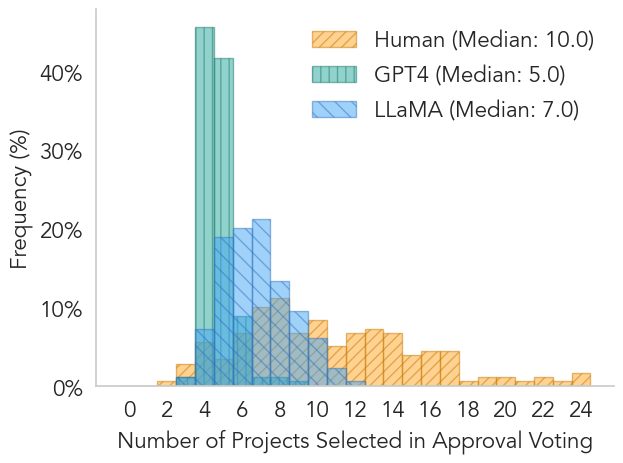

In [53]:
import json
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({'font.size': 12, 'font.family': 'Avenir'})

def load_data(filename):
    """Loads voting data from a JSON file and returns the number of votes for each entry."""
    with open(filename, 'r') as file:
        data = json.load(file)
    if 'Inputs' in data[0]:
        vote_counts = [sum(1 for vote in item['Inputs']['voteA'] if vote != 0) for item in data]
    else:
        vote_counts = [len(item['votes']) for item in data]
    return vote_counts

# Load vote counts from JSON files
vote_counts_h = load_data('lab_vote/responses.json')
vote_counts_g = load_data('gpt_vote/votes_appr.json')
vote_counts_l = load_data('llama_vote/votes_llama70bq8_appr_1.json')

# Calculate medians
median_h = np.median(vote_counts_h)
median_g = np.median(vote_counts_g)
median_l = np.median(vote_counts_l)

# Define colors and hatches
human_color = '#FFA726'
llama_color = '#42A5F5'
gpt_color = '#26A69A'
human_hatch_color = '#C77800' 
llama_hatch_color = '#3173C4' 
gpt_hatch_color = '#1B786D'   
human_hatch = '///'
llama_hatch = '\\\\'
gpt_hatch = '||'

# Plot histograms
bins = np.arange(26) - 0.5
plt.hist(vote_counts_h, bins=bins, alpha=0.5, label=f'Human (Median: {median_h})', density=True, color=human_color, hatch=human_hatch, edgecolor=human_hatch_color)
plt.hist(vote_counts_g, bins=bins, alpha=0.5, label=f'GPT4 (Median: {median_g})', density=True, color=gpt_color, hatch=gpt_hatch, edgecolor=gpt_hatch_color)
plt.hist(vote_counts_l, bins=bins, alpha=0.5, label=f'LLaMA (Median: {median_l})', density=True, color=llama_color, hatch=llama_hatch, edgecolor=llama_hatch_color)
plt.gcf().set_facecolor('white')

# Set labels and legend
plt.xlabel('Number of Projects Selected in Approval Voting', fontsize=16)
plt.ylabel('Frequency (%)', fontsize=16)
plt.legend(frameon=False, fontsize=16)

# Set x-ticks and y-ticks
plt.xticks(np.arange(0, 26, 2), fontsize=16)
plt.yticks(fontsize=16)

# Adjust y-axis labels to show percentages
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0f}%'.format(y * 100)))

# Improve plot aesthetics
plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('../figures/frequency.pdf', format='pdf')
plt.show()


# Histogram of Sum of Points Assigned in Cumulative Voting

This script visualizes the distribution of the total points assigned to projects in a cumulative voting scenario by GPT-4 and LLaMA models. The histogram displays the frequency (as percentages) of different sums of points, providing insights into how often each model assigned various total points across projects. 


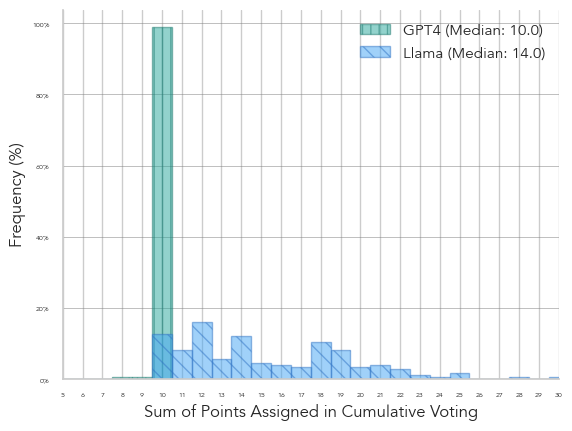

In [54]:
import json
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = 'Avenir'

def load_data_and_sum_points(filename):
    with open(filename, 'r') as file:
        data = json.load(file)
    sum_of_points = [sum(votes.values()) for votes in (item['votes'] for item in data)]
    return sum_of_points

sum_of_points_gpt4t = load_data_and_sum_points('gpt_vote/votes_cumu_corrected.json')
sum_of_points_llama = load_data_and_sum_points('llama_vote/votes_llama70bq8_cumu_1.json')

median_gpt4t = np.median(sum_of_points_gpt4t)
median_llama = np.median(sum_of_points_llama)

gpt_color = '#26A69A'
llama_color = '#42A5F5'
gpt_hatch_color = '#1B786D'  
llama_hatch_color = '#3173C4'  
gpt_hatch = '||'
llama_hatch = '\\\\'

bins = np.arange(max(max(sum_of_points_gpt4t), max(sum_of_points_llama)) + 2) - 0.5 
plt.hist(sum_of_points_gpt4t, bins=bins, alpha=0.5, label=f'GPT4 (Median: {median_gpt4t})', density=True, color=gpt_color, hatch=gpt_hatch, edgecolor=gpt_hatch_color)
plt.hist(sum_of_points_llama, bins=bins, alpha=0.5, label=f'Llama (Median: {median_llama})', density=True, color=llama_color, hatch=llama_hatch, edgecolor=llama_hatch_color)

plt.gca().set_facecolor('white')  
plt.gcf().set_facecolor('white')

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0f}%'.format(y * 100)))

plt.xlabel('Sum of Points Assigned in Cumulative Voting')
plt.ylabel('Frequency (%)')
# plt.title('Frequency of Sum of Points in Cumulative Voting')
plt.legend(frameon=False)
plt.xticks(np.arange(max(max(sum_of_points_gpt4t), max(sum_of_points_llama)) + 1))
plt.xlim(5,30)

plt.grid(axis='y', which='major', linestyle='-', linewidth=0.5, alpha=0.7, color='grey')

sns.despine()
# plt.gca().spines['top'].set_visible(False)  
# plt.gca().spines['right'].set_visible(False)  
# plt.gca().spines['bottom'].set_visible(True)  
# plt.gca().spines['left'].set_visible(True) 

plt.show()
